In [59]:
import json
import psycopg2
import urllib.parse as up
import pandas as pd
import re
import urllib3
from datetime import date
import os
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib
import numpy
import seaborn as sns
from matplotlib import pyplot as plt

Connect to Database and convert relevent data into a DataFrame

In [64]:
#Connect to Database

parentDir = os.path.dirname(os.getcwd())
cred = json.load(open(parentDir+'/PSQLCredentials.json'))


url = up.urlparse(cred[1]['connString'])


print(url)

conn = psycopg2.connect(database=url.path[1:], user=url.username, password=url.password, host=url.hostname, port=url.port )

cursor  = conn.cursor()
cursor.execute("select * from (select caryear, mileage, model, ownercount, accidentcount, price, Case When transmission like '%Manual%' Then 'Manual' When transmission like '%Automatic%' Then 'Automatic' Else 'Unknown' End transmission from listings where caryear is not null and mileage is not null and transmission is not null and model is not null and accidentcount is not null and ownercount is not null) a where a.transmission != 'Unknown'")
conn.commit()
df = pd.DataFrame(cursor.fetchall())



cursor .close()
conn.close()
#Add column names to dataframe
df = df.rename(columns = {0:'Year', 1:'Mileage', 2: 'Maker', 3:'OwnerCount', 4:'AccidentCount', 5:'Price', 6:'Transmission'})
#Convert all numerical data into float
df[["Price"]] = df[["Price"]].apply(pd.to_numeric)
#Create dummy data for categorical data types
df['Maker'] = df['Maker'].map({'Toyota 86': 0, 'Subaru BRZ': 1})
print(df)

ParseResult(scheme='postgres', netloc='gwiisjlfxssptu:e69c7bc02a1e8febf09e2444f3dde77b9b940107237e28cf7cb2c0d3bccf3820@ec2-3-219-229-143.compute-1.amazonaws.com:5432', path='/da221a7t1hngcv', params='', query='', fragment='')


OperationalError: could not connect to server: Connection timed out (0x0000274C/10060)
	Is the server running on host "ec2-3-219-229-143.compute-1.amazonaws.com" (3.219.229.143) and accepting
	TCP/IP connections on port 5432?


Testing Linear regression assumptions
1) Linear relationship
2) X variables are normally distributed
3) Minimal Multicollinearity
4) Homoscedastic

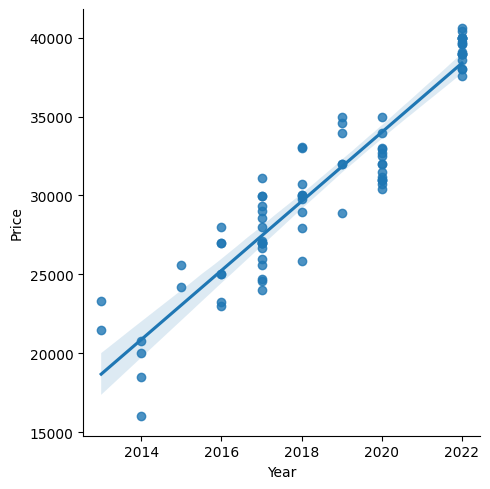

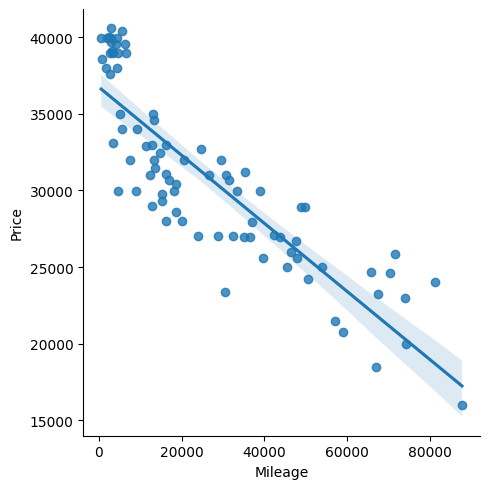

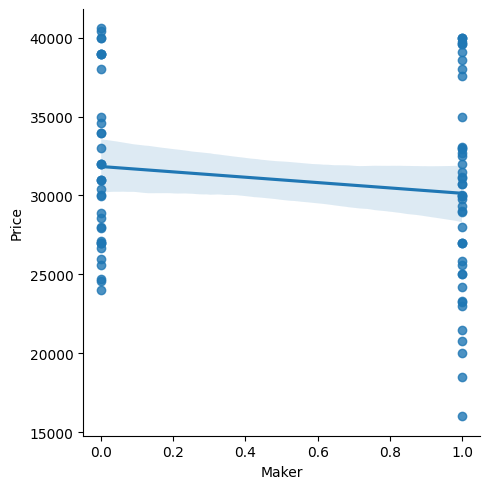

In [49]:
sns.lmplot(x="Year", y = "Price", data = df, order=1)
sns.lmplot(x="Mileage", y = "Price", data = df, order=1)
sns.lmplot(x="Maker", y = "Price", data = df, order=1)


In [40]:
print(df.dtypes)

Year               int64
Mileage            int64
Maker             object
OwnerCount         int64
AccidentCount      int64
Price            float64
Transmission      object
dtype: object
